In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import heracles
import heracles.dices as dices
from heracles.io import read

# SpaceBorne Vs DICES

- Binned [x]
- Non-Gaussian [x]
- Partial Sky [ ]

In [2]:
nside = 256
lmax = nside
mode = "gaussian"
sims_path = f"{mode}_sims/{mode}_sim_1/"
apply_mask = False
binned = False
nbins = 3
Njk = 30

save = True
output_path = f"{mode}_dices/"
if apply_mask:
    output_path = "./masked_"+output_path
else:
    output_path = "./"+output_path

ls = np.arange(lmax+1)

## Comparison

In [3]:
theory_cls = heracles.read(f"{mode}_sims/{mode}_sim_1/theory_cls.fits")
if binned:
    for key in list(theory_cls.keys()):
        theory_cls[key] = heracles.binned(theory_cls[key], ledges)

fl = -np.sqrt((ls+2)*(ls+1)*ls*(ls-1))
fl /= np.clip(ls*(ls+1), 1, None)

_theory_cls = {}
_theory_cls[("POS", "POS", 1, 1)] = theory_cls["W1xW1"]
_theory_cls[("POS", "POS", 2, 2)] = theory_cls["W2xW2"]
_theory_cls[("G_E", "G_E", 1, 1)] = theory_cls["W3xW3"].__array__()*fl**2
_theory_cls[("G_E", "G_E", 2, 2)] = theory_cls["W4xW4"].__array__()*fl**2
_theory_cls[("POS", "G_E", 1, 1)] = theory_cls["W1xW3"].__array__()*fl
_theory_cls[("POS", "G_E", 2, 2)] = theory_cls["W2xW4"].__array__()*fl
_theory_cls[("POS", "POS", 1, 2)] = theory_cls["W1xW2"]
_theory_cls[("POS", "G_E", 1, 2)] = theory_cls["W1xW4"].__array__()*fl
_theory_cls[("POS", "G_E", 2, 1)] = theory_cls["W2xW3"].__array__()*fl
_theory_cls[("G_E", "G_E", 1, 2)] = theory_cls["W3xW4"].__array__()*fl**2

_theory_cls[("G_B", "G_B", 1, 1)] = np.zeros_like(theory_cls["W3xW3"])
_theory_cls[("G_B", "G_B", 2, 2)] = np.zeros_like(theory_cls["W3xW3"])
_theory_cls[("POS", "G_B", 1, 1)] = np.zeros_like(theory_cls["W3xW3"])
_theory_cls[("POS", "G_B", 2, 2)] = np.zeros_like(theory_cls["W3xW3"])
_theory_cls[("POS", "G_B", 1, 2)] = np.zeros_like(theory_cls["W3xW3"])
_theory_cls[("POS", "G_B", 2, 1)] = np.zeros_like(theory_cls["W3xW3"])
_theory_cls[("G_B", "G_B", 1, 2)] = np.zeros_like(theory_cls["W3xW3"])

In [4]:
if binned:
    if apply_mask:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cqs_wmask.fits")
    else:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cqs.fits")
else:
    if apply_mask:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cls_wmask.fits")
    else:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cls.fits") 

In [6]:
cov1 = read(output_path + "covs/cov1_njk_%i_binned_%i.fits" % (Njk, binned))
dices_cov = read(output_path + "covs/cov2_njk_%i_binned_%i.fits" % (Njk, binned))
#dices_cov = read(output_path + "covs/dices_njk_%i_binned_%i.fits" % (Njk, binned))
sb_cov = np.load("./data/sb_cov_dict.npz", allow_pickle=True)["arr_0"].item()

/tmp/ipykernel_83555/1217563573.py:13: RuntimeWarning: invalid value encountered in sqrt
  dcerr = np.sqrt(np.diag(dc))


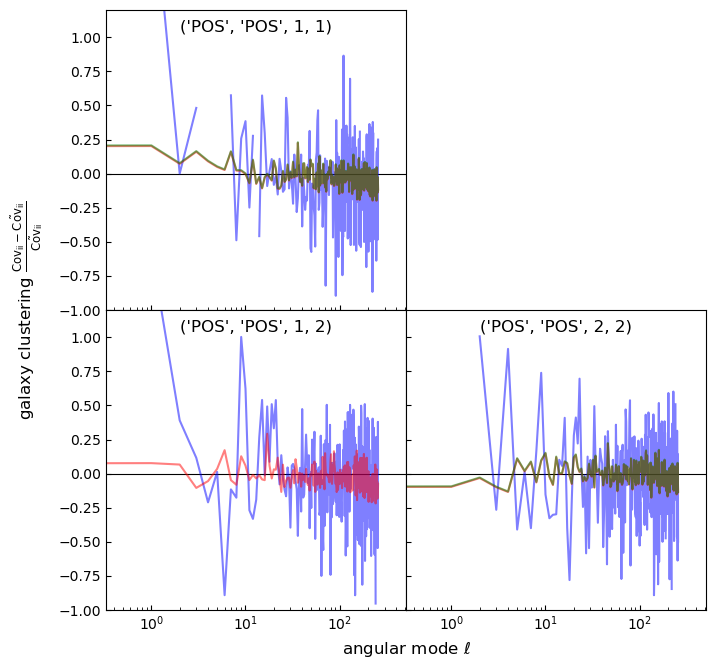

In [7]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("POS", "POS", i, j)
        kk = ("POS", "POS",  "POS", "POS", i, j, i, j)
        sb_kk = ("POS", "POS",  "POS", "POS", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].__array__()
        dc = dices_cov[kk]
        ens_err = np.sqrt(np.diag(ensemble_cov[key]))
        dcerr = np.sqrt(np.diag(dc))
        sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/np.sqrt((np.pi))

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        if i == j:
            gc = np.sqrt((2*_vcl**2)/(2*ls+1))
            ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(key, y=0.9)


ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(10, lmax * 2)
else:
    ax[0, 0].set_xlim(1 / 3, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-1, 1.2)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"galaxy clustering $\frac{\rm{Cov}_{ii}-\tilde{\rm{Cov}}_{ii}}{\tilde{\rm{Cov}}_{ii}}$", x=-0.1, ha="right")

plt.show()

/tmp/ipykernel_83555/1051959207.py:13: RuntimeWarning: invalid value encountered in sqrt
  dcerr = np.sqrt(np.diag(dc))
/tmp/ipykernel_83555/1051959207.py:16: RuntimeWarning: invalid value encountered in divide
  ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
/tmp/ipykernel_83555/1051959207.py:17: RuntimeWarning: divide by zero encountered in divide
  ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
/tmp/ipykernel_83555/1051959207.py:17: RuntimeWarning: invalid value encountered in divide
  ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
/tmp/ipykernel_83555/1051959207.py:20: RuntimeWarning: invalid value encountered in divide
  ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')


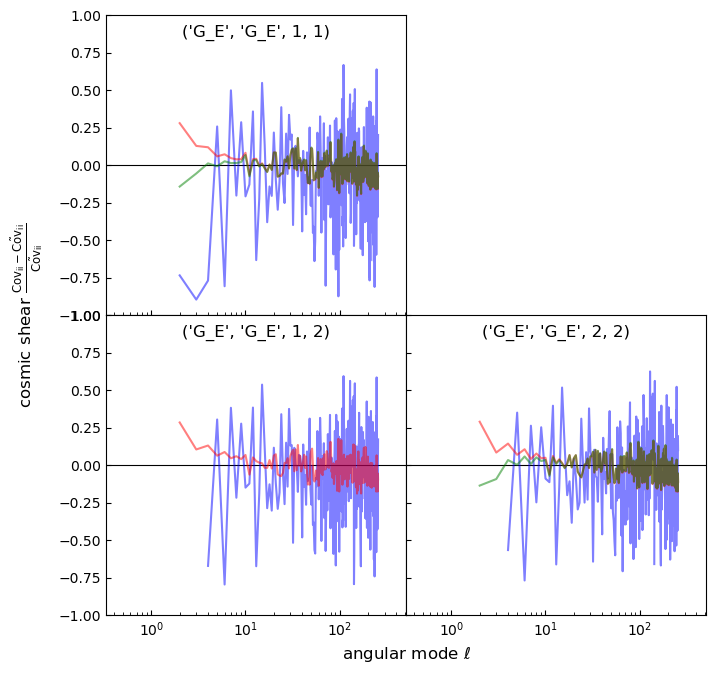

In [13]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("G_E", "G_E", i, j)
        kk = ("SHE", "SHE",  "SHE", "SHE", i, j, i, j)
        sb_kk = ("G_E", "G_E",  "G_E", "G_E", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].__array__()
        dc = dices_cov[kk][0, 0, :, :]
        ens_err = np.sqrt(np.diag(ensemble_cov[key]))
        dcerr = np.sqrt(np.diag(dc))
        sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/np.sqrt((np.pi))

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        if i == j:
            gc = np.sqrt((2*_vcl**2)/(2*ls+1))
            ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(key, y=0.9)
ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(10, lmax * 2)
else:
    ax[0, 0].set_xlim(1 / 3, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-1, 1)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"cosmic shear $\frac{\rm{Cov}_{ii}-\tilde{\rm{Cov}}_{ii}}{\tilde{\rm{Cov}}_{ii}}$", x=-0.1, ha="right")

plt.show()

/tmp/ipykernel_83555/1620334292.py:16: RuntimeWarning: invalid value encountered in divide
  ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')


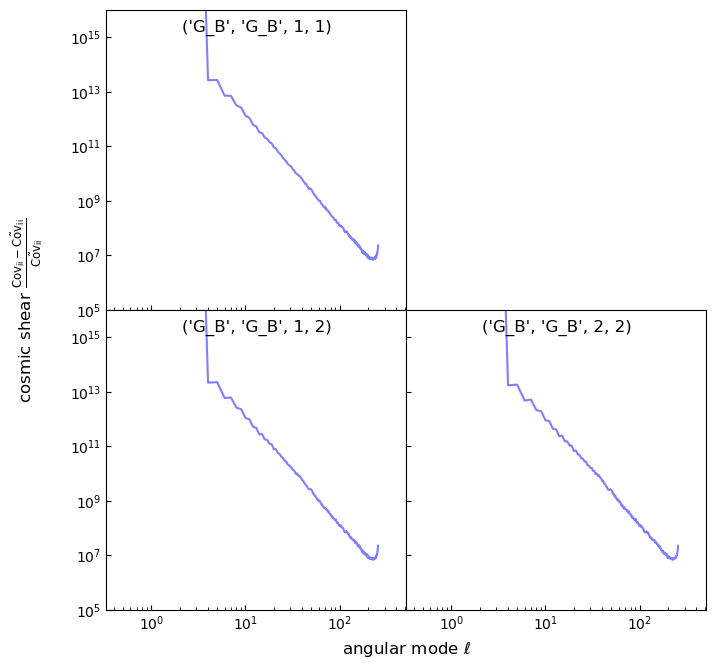

In [29]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("G_B", "G_B", i, j)
        kk = ("SHE", "SHE",  "SHE", "SHE", i, j, i, j)
        sb_kk = ("G_B", "G_B",  "G_B", "G_B", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].__array__()
        dc = np.abs(dices_cov[kk][1, 1, :, :])
        ens_err = np.sqrt(np.diag(ensemble_cov[key]))
        dcerr = np.sqrt(np.diag(dc))
        #sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/np.sqrt((np.pi))

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
        #ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        #if i == j:
        #    gc = np.sqrt((2*_vcl**2)/(2*ls+1))
        #    ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(key, y=0.9)
ax[0, 0].set_xscale("log")
ax[0, 0].set_yscale("log")
if binned:
    ax[0, 0].set_xlim(10, lmax * 2)
else:
    ax[0, 0].set_xlim(1 / 3, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(10**5, 10**16)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"cosmic shear $\frac{\rm{Cov}_{ii}-\tilde{\rm{Cov}}_{ii}}{\tilde{\rm{Cov}}_{ii}}$", x=-0.1, ha="right")

plt.show()

/tmp/ipykernel_83555/2349673144.py:11: RuntimeWarning: invalid value encountered in sqrt
  dcerr = np.sqrt(np.diag(dc))
/tmp/ipykernel_83555/2349673144.py:14: RuntimeWarning: divide by zero encountered in divide
  ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
/tmp/ipykernel_83555/2349673144.py:15: RuntimeWarning: divide by zero encountered in divide
  ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
/tmp/ipykernel_83555/2349673144.py:15: RuntimeWarning: invalid value encountered in divide
  ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
/tmp/ipykernel_83555/2349673144.py:18: RuntimeWarning: invalid value encountered in divide
  ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')


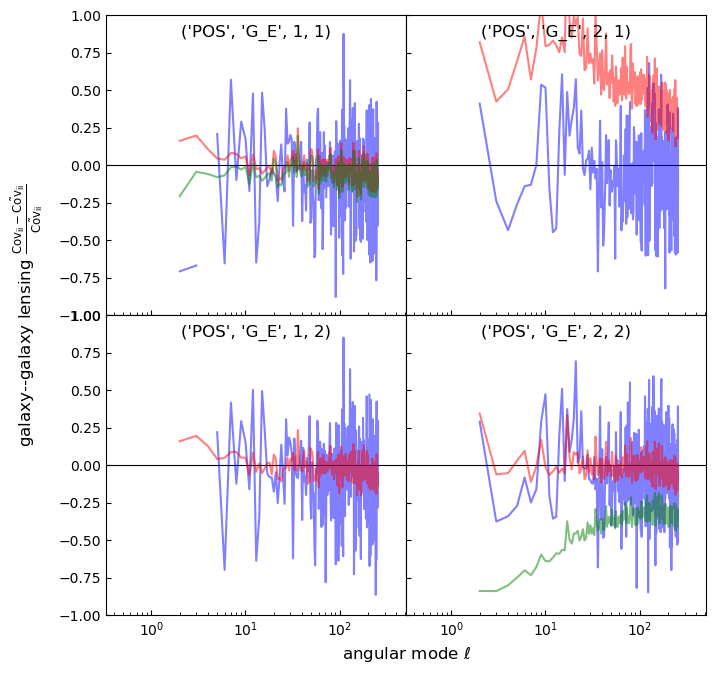

In [24]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, nbins):
        key = ("POS", "G_E", i, j)
        kk = ("POS", "SHE",  "POS", "SHE", i, j, i, j)
        sb_kk = ("POS", "G_E",  "POS", "G_E", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].__array__()
        dc = dices_cov[kk][0, 0, :, :]
        ens_err = np.sqrt(np.diag(ensemble_cov[key]))
        dcerr = np.sqrt(np.diag(dc))
        sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/np.sqrt((np.pi))

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        if i == j:
            gc = np.sqrt((2*_vcl**2)/(2*ls+1))
            ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(key, y=0.9)

ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(10, lmax * 2)
else:
    ax[0, 0].set_xlim(1 / 3, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-1, 1)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"galaxy--galaxy lensing $\frac{\rm{Cov}_{ii}-\tilde{\rm{Cov}}_{ii}}{\tilde{\rm{Cov}}_{ii}}$", x=-0.1, ha="right")

plt.show()

/tmp/ipykernel_83555/744234079.py:14: RuntimeWarning: divide by zero encountered in divide
  ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')


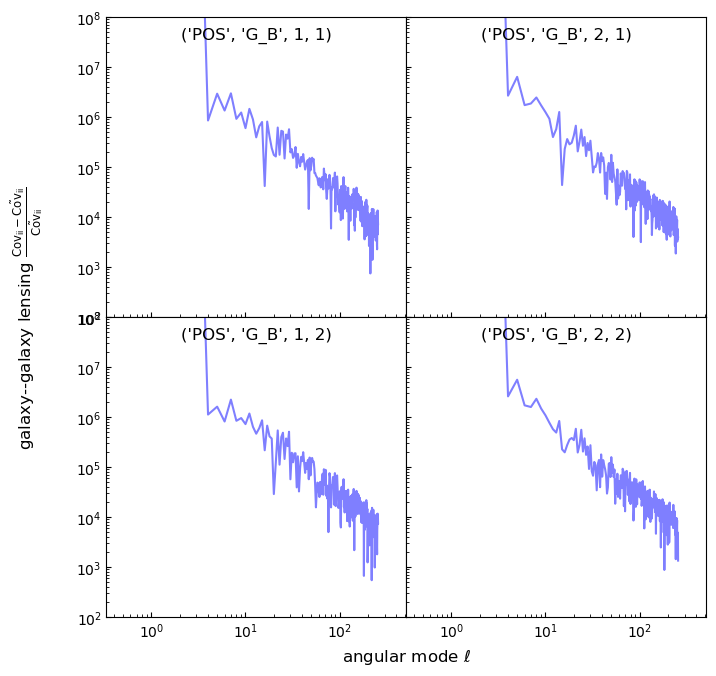

In [31]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, nbins):
        key = ("POS", "G_B", i, j)
        kk = kk = ("POS", "SHE",  "POS", "SHE", i, j, i, j)
        sb_kk = ("POS", "G_B",  "POS", "G_B", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].__array__()
        dc = np.abs(dices_cov[kk][0, 1, :, :])
        ens_err = np.sqrt(np.diag(ensemble_cov[key]))
        dcerr = np.sqrt(np.diag(dc))
        #sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/2

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
        #ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        #if i == j:
        #    gc = np.sqrt((2*_vcl**2)/(2*ls+1))
        #    ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g--', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(key, y=0.9)

ax[0, 0].set_xscale("log")
ax[0, 0].set_yscale("log")
if binned:
    ax[0, 0].set_xlim(10, lmax * 2)
else:
    ax[0, 0].set_xlim(1 / 3, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(10**2, 10**8)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"galaxy--galaxy lensing $\frac{\rm{Cov}_{ii}-\tilde{\rm{Cov}}_{ii}}{\tilde{\rm{Cov}}_{ii}}$", x=-0.1, ha="right")

plt.show()